# Imports

In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Prepare the Dataset
You will load the MNIST data from TFDS into train and test sets. Let's first define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return `image, image` because the input will also be the target or label while training.


In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = datasets.MNIST('MNIST/', train=True, download=True, transform=transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 92624500.67it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 54664121.76it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23520720.04it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11063024.84it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



# Build the Model
You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output.

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=28*28, out_features=256)
        self.layer2 = nn.Linear(in_features=256, out_features=128)
        self.layer3 = nn.Linear(in_features=128, out_features=64)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.layer1(x); x = self.relu(x) 
        x = self.layer2(x); x = self.relu(x)
        x = self.layer3(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=64, out_features=128)
        self.layer2 = nn.Linear(in_features=128, out_features=256)
        self.layer3 = nn.Linear(in_features=256, out_features=28*28)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x); x = self.relu(x) 
        x = self.layer2(x); x = self.relu(x)
        x = self.layer3(x); x = self.sigmoid(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
autoencoder = AutoEncoder(encoder, decoder).to(device)

# Train Model

In [6]:
optimizer = torch.optim.Adam(params=autoencoder.parameters())
loss_fn = nn.MSELoss()

In [7]:
# Training loop

losses = []
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        flattened_inputs = inputs.reshape(-1, 28*28)

        # Forward pass
        outputs = autoencoder(flattened_inputs)
        loss = loss_fn(outputs, flattened_inputs)

        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss/len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch} | Loss: {avg_loss}")

Epoch 0 | Loss: 0.051006399492210926
Epoch 1 | Loss: 0.023810129199645667
Epoch 2 | Loss: 0.018102695246034466
Epoch 3 | Loss: 0.015040270928571473
Epoch 4 | Loss: 0.012895802407265344
Epoch 5 | Loss: 0.011395433389428836
Epoch 6 | Loss: 0.010336974810467347
Epoch 7 | Loss: 0.009577552337191507
Epoch 8 | Loss: 0.0089421546571195
Epoch 9 | Loss: 0.008421865394160247


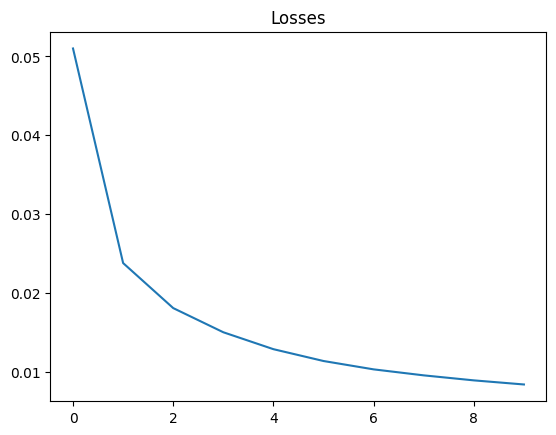

In [11]:
plt.plot(losses)
plt.title("Losses")
plt.show()

## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

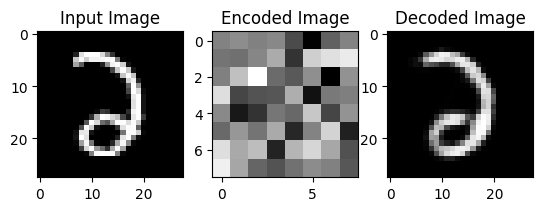

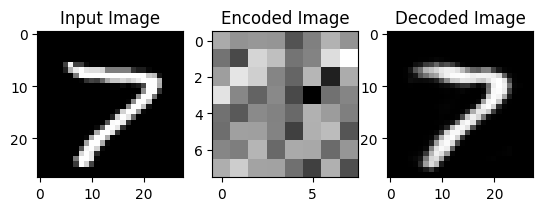

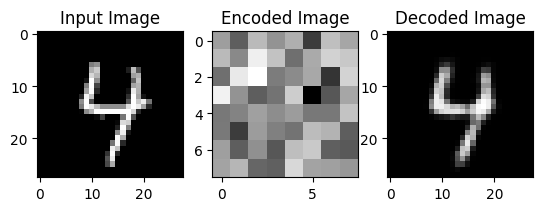

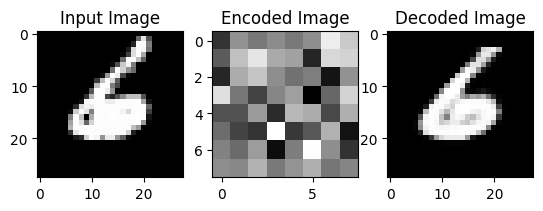

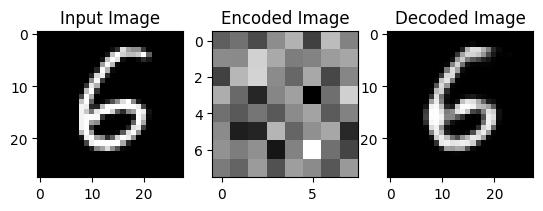

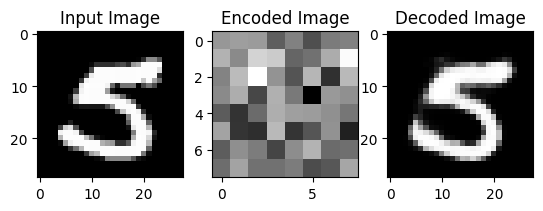

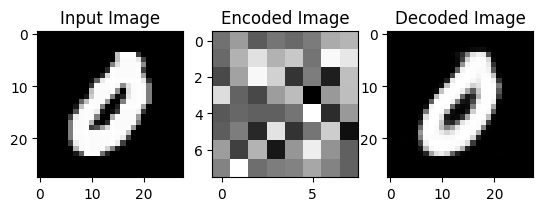

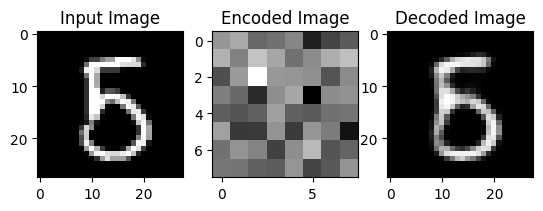

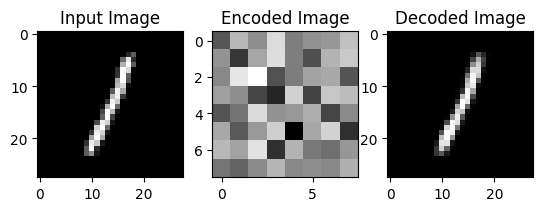

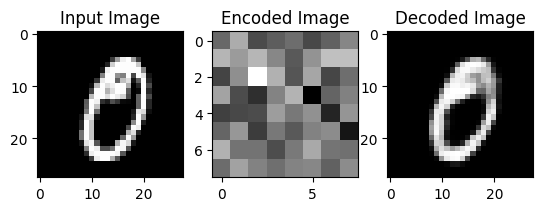

In [9]:
image, label = next(iter(train_loader))
sample = image[10:20]

for i, img in enumerate(sample, 0):
    img = img.to(device)
    img_shape = img.size()
    with torch.inference_mode():
        encoded = encoder(img.reshape(-1, 28*28))
        decoded = autoencoder(img.reshape(-1, 28*28))

    encoded_image = encoded.view(8,8)
    decoded_image = decoded.view(img_shape).squeeze(dim=0)
    
    plt.subplot(1,3,1)
    plt.imshow(img.cpu().squeeze(dim=0), cmap='gray')
    plt.title('Input Image')

    plt.subplot(1,3,2)
    plt.imshow(encoded_image.cpu(), cmap='gray')
    plt.title('Encoded Image')

    plt.subplot(1,3,3)
    plt.imshow(decoded_image.cpu(), cmap='gray')
    plt.title('Decoded Image')
    plt.show()
